In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

In [5]:
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = "Malgun Gothic"

In [6]:
import pprint
import yfinance as yf

ticker = yf.Ticker("AAPL")
pprint.pprint(ticker.info)

print(ticker.history(ticker.info))

{'52WeekChange': -0.061412036,
 'SandP52WeekChange': 0.1185931,
 'address1': 'One Apple Park Way',
 'ask': 223.71,
 'askSize': 1,
 'auditRisk': 7,
 'averageAnalystRating': '2.1 - Buy',
 'averageDailyVolume10Day': 65419500,
 'averageDailyVolume3Month': 63501154,
 'averageVolume': 63501154,
 'averageVolume10days': 65419500,
 'beta': 1.211,
 'bid': 198.41,
 'bidSize': 1,
 'boardRisk': 1,
 'bookValue': 4.471,
 'city': 'Cupertino',
 'companyOfficers': [{'age': 63,
                      'exercisedValue': 0,
                      'fiscalYear': 2024,
                      'maxAge': 1,
                      'name': 'Mr. Timothy D. Cook',
                      'title': 'CEO & Director',
                      'totalPay': 16520856,
                      'unexercisedValue': 0,
                      'yearBorn': 1961},
                     {'age': 60,
                      'exercisedValue': 0,
                      'fiscalYear': 2024,
                      'maxAge': 1,
                      'name': '

AttributeError: 'dict' object has no attribute 'lower'

In [7]:
print(ticker.history(period = "5d"))

                                 Open        High         Low       Close  \
Date                                                                        
2025-06-26 00:00:00-04:00  201.429993  202.639999  199.460007  201.000000   
2025-06-27 00:00:00-04:00  201.889999  203.220001  200.000000  201.080002   
2025-06-30 00:00:00-04:00  202.009995  207.389999  199.259995  205.169998   
2025-07-01 00:00:00-04:00  206.669998  210.190002  206.139999  207.820007   
2025-07-02 00:00:00-04:00  208.910004  213.339996  208.139999  212.440002   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-06-26 00:00:00-04:00  50799100        0.0           0.0  
2025-06-27 00:00:00-04:00  73188600        0.0           0.0  
2025-06-30 00:00:00-04:00  91912800        0.0           0.0  
2025-07-01 00:00:00-04:00  78788900        0.0           0.0  
2025-07-02 00:00:00-04:00  67893400        0.0           0.0  


In [10]:
smasung = yf.download('005930.KS', start = '2000-01-01', end = '2023-12-31')
smasung.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,005930.KS,005930.KS,005930.KS,005930.KS,005930.KS
Date,,,,,
2000-01-04,4349.560547,4349.560547,4029.216480,4271.254220,74195000
2000-01-05,3972.263916,4313.964038,3929.551401,4128.876472,74680000
2000-01-06,4000.739990,4114.640061,3972.264973,4093.283798,54390000
2000-01-07,3943.790039,4036.333849,3815.652457,3958.027548,40305000
2000-01-10,4107.520996,4107.520996,3972.264672,3986.502180,46880000


In [60]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import itertools
import warnings
warnings.filterwarnings('ignore')

# 1. 데이터 다운로드
df = yf.download('000660.KS', start='2020-01-01', end='2025-06-30')[['Close']].reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])


train = df[df['ds'] <= '2024-12-31'].copy()
test = df[df['ds'] >= '2025-01-01'].copy()

# 추세 변화 민감도: 클수록 추세 변화를 더 민감하게 감지 (과적합 위험 증가)
changepoint_prior_scales = [0.001, 0.01, 0.1]

# 계절성 민감도: 클수록 더 복잡한 계절성 패턴을 허용
seasonality_prior_scales = [1.0, 10.0]

# 계절성 모드:
# 'additive' → y에 일정량 더해지는 형태 (ex. 매년 비슷한 금액의 변화)
# 'multiplicative' → y의 크기에 비례해 변화 (ex. 매출이 커질수록 더 큰 계절성 진폭)
seasonality_modes = ['additive', 'multiplicative']

# 추세 변화점이 전체 학습 구간 중 앞쪽 몇 %에 포함될지 결정
# 0.8 → 처음 80%에만 변화점 배치
changepoint_ranges = [0.8, 0.9]

# 모델이 허용하는 추세 변화점 개수
n_changepoints_list = [10, 25, 50]

# 연간 계절성 반영 여부
yearly_opts = [True, False]

# 주간 계절성 반영 여부
weekly_opts = [True, False]

# 일간 계절성 반영 여부
daily_opts = [True, False]



param_combinations = itertools.product(
    changepoint_prior_scales,
    seasonality_prior_scales,
    seasonality_modes,
    changepoint_ranges,
    n_changepoints_list,
    yearly_opts,
    weekly_opts,
    daily_opts
)


results = []

for cps, sps, mode, cpr, n_cp, yearly, weekly, daily in param_combinations:
    try:
        model = Prophet(
            changepoint_prior_scale=cps,
            seasonality_prior_scale=sps,
            seasonality_mode=mode,
            changepoint_range=cpr,
            n_changepoints=n_cp,
            yearly_seasonality=yearly,
            weekly_seasonality=weekly,
            daily_seasonality=daily)
        
        model.fit(train)
        future = pd.DataFrame({'ds': pd.date_range(start=df['ds'].min(), end= test['ds'].max())})
        forecast = model.predict(future)

        pred = forecast[['ds', 'yhat']].set_index('ds')
        merged = test.set_index('ds').join(pred, how='left')
        
        results.append({
                        'changepoint_prior_scale': cps,
                        'seasonality_prior_scale': sps,
                        'seasonality_mode': mode,
                        'changepoint_range': cpr,
                        'n_changepoints': n_cp,
                        'yearly': yearly,
                        'weekly': weekly,
                        'daily': daily,
                        'MAE': mae
                    })
    except Exception as e:
        print(e)



[*********************100%***********************]  1 of 1 completed
08:18:40 - cmdstanpy - INFO - Chain [1] start processing
08:18:40 - cmdstanpy - INFO - Chain [1] done processing
08:18:40 - cmdstanpy - INFO - Chain [1] start processing
08:18:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:41 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:41 - cmdstanpy - INFO - Chain [1] done processing
08:18:41 - cmdstanpy - INFO - Chain [1] start processing
08:18:41 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:42 - cmdstanpy - INFO - Chain [1] start processing
08:18:42 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:42 - cmdstanpy - INFO - Chain [1] start processing
08:18:42 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:42 - cmdstanpy - INFO - Chain [1] start processing
08:18:42 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:43 - cmdstanpy - INFO - Chain [1] start processing
08:18:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:43 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:43 - cmdstanpy - INFO - Chain [1] done processing
08:18:43 - cmdstanpy - INFO - Chain [1] start processing
08:18:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:44 - cmdstanpy - INFO - Chain [1] start processing
08:18:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:44 - cmdstanpy - INFO - Chain [1] start processing
08:18:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:44 - cmdstanpy - INFO - Chain [1] start processing
08:18:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:45 - cmdstanpy - INFO - Chain [1] start processing
08:18:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:45 - cmdstanpy - INFO - Chain [1] start processing
08:18:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:45 - cmdstanpy - INFO - Chain [1] start processing
08:18:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:46 - cmdstanpy - INFO - Chain [1] done processing
08:18:46 - cmdstanpy - INFO - Chain [1] start processing
08:18:46 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:47 - cmdstanpy - INFO - Chain [1] start processing
08:18:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:47 - cmdstanpy - INFO - Chain [1] start processing
08:18:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:47 - cmdstanpy - INFO - Chain [1] start processing
08:18:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:48 - cmdstanpy - INFO - Chain [1] start processing
08:18:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:48 - cmdstanpy - INFO - Chain [1] start processing
08:18:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:48 - cmdstanpy - INFO - Chain [1] start processing
08:18:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:49 - cmdstanpy - INFO - Chain [1] start processing
08:18:49 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:49 - cmdstanpy - INFO - Chain [1] start processing
08:18:49 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:49 - cmdstanpy - INFO - Chain [1] start processing
08:18:50 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:50 - cmdstanpy - INFO - Chain [1] start processing
08:18:50 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:50 - cmdstanpy - INFO - Chain [1] start processing
08:18:50 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:51 - cmdstanpy - INFO - Chain [1] start processing
08:18:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:51 - cmdstanpy - INFO - Chain [1] start processing
08:18:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:51 - cmdstanpy - INFO - Chain [1] start processing
08:18:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:52 - cmdstanpy - INFO - Chain [1] start processing
08:18:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:52 - cmdstanpy - INFO - Chain [1] start processing
08:18:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:52 - cmdstanpy - INFO - Chain [1] start processing
08:18:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:53 - cmdstanpy - INFO - Chain [1] start processing
08:18:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:53 - cmdstanpy - INFO - Chain [1] start processing
08:18:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:53 - cmdstanpy - INFO - Chain [1] start processing
08:18:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:54 - cmdstanpy - INFO - Chain [1] start processing
08:18:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:54 - cmdstanpy - INFO - Chain [1] start processing
08:18:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:54 - cmdstanpy - INFO - Chain [1] done processing
08:18:55 - cmdstanpy - INFO - Chain [1] start processing
08:18:55 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:55 - cmdstanpy - INFO - Chain [1] done processing
08:18:55 - cmdstanpy - INFO - Chain [1] start processing
08:18:56 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:56 - cmdstanpy - INFO - Chain [1] start processing
08:18:56 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:56 - cmdstanpy - INFO - Chain [1] start processing
08:18:56 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:57 - cmdstanpy - INFO - Chain [1] start processing
08:18:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:57 - cmdstanpy - INFO - Chain [1] start processing
08:18:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:57 - cmdstanpy - INFO - Chain [1] done processing
08:18:58 - cmdstanpy - INFO - Chain [1] start processing
08:18:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:58 - cmdstanpy - INFO - Chain [1] done processing
08:18:58 - cmdstanpy - INFO - Chain [1] start processing
08:18:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:59 - cmdstanpy - INFO - Chain [1] start processing
08:18:59 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:59 - cmdstanpy - INFO - Chain [1] start processing
08:18:59 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:18:59 - cmdstanpy - INFO - Chain [1] start processing
08:18:59 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:00 - cmdstanpy - INFO - Chain [1] start processing
08:19:00 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:00 - cmdstanpy - INFO - Chain [1] done processing
08:19:01 - cmdstanpy - INFO - Chain [1] start processing
08:19:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:01 - cmdstanpy - INFO - Chain [1] start processing
08:19:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:01 - cmdstanpy - INFO - Chain [1] start processing
08:19:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:02 - cmdstanpy - INFO - Chain [1] start processing
08:19:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:02 - cmdstanpy - INFO - Chain [1] start processing
08:19:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:02 - cmdstanpy - INFO - Chain [1] start processing
08:19:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:03 - cmdstanpy - INFO - Chain [1] start processing
08:19:03 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:03 - cmdstanpy - INFO - Chain [1] done processing
08:19:03 - cmdstanpy - INFO - Chain [1] start processing
08:19:03 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:04 - cmdstanpy - INFO - Chain [1] start processing
08:19:04 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:04 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:04 - cmdstanpy - INFO - Chain [1] done processing
08:19:04 - cmdstanpy - INFO - Chain [1] start processing
08:19:05 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:05 - cmdstanpy - INFO - Chain [1] start processing
08:19:05 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:05 - cmdstanpy - INFO - Chain [1] start processing
08:19:05 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:05 - cmdstanpy - INFO - Chain [1] start processing
08:19:06 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:06 - cmdstanpy - INFO - Chain [1] start processing
08:19:06 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:06 - cmdstanpy - INFO - Chain [1] start processing
08:19:06 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:07 - cmdstanpy - INFO - Chain [1] start processing
08:19:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:07 - cmdstanpy - INFO - Chain [1] start processing
08:19:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:07 - cmdstanpy - INFO - Chain [1] start processing
08:19:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:08 - cmdstanpy - INFO - Chain [1] start processing
08:19:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:08 - cmdstanpy - INFO - Chain [1] start processing
08:19:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:08 - cmdstanpy - INFO - Chain [1] start processing
08:19:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:09 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:09 - cmdstanpy - INFO - Chain [1] done processing
08:19:09 - cmdstanpy - INFO - Chain [1] start processing
08:19:09 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:10 - cmdstanpy - INFO - Chain [1] start processing
08:19:10 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:10 - cmdstanpy - INFO - Chain [1] start processing
08:19:10 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:10 - cmdstanpy - INFO - Chain [1] start processing
08:19:10 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:11 - cmdstanpy - INFO - Chain [1] start processing
08:19:11 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:11 - cmdstanpy - INFO - Chain [1] start processing
08:19:11 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:11 - cmdstanpy - INFO - Chain [1] start processing
08:19:11 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:12 - cmdstanpy - INFO - Chain [1] start processing
08:19:12 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:12 - cmdstanpy - INFO - Chain [1] start processing
08:19:12 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:12 - cmdstanpy - INFO - Chain [1] done processing
08:19:13 - cmdstanpy - INFO - Chain [1] start processing
08:19:13 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:13 - cmdstanpy - INFO - Chain [1] start processing
08:19:13 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:14 - cmdstanpy - INFO - Chain [1] start processing
08:19:14 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:14 - cmdstanpy - INFO - Chain [1] start processing
08:19:14 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:14 - cmdstanpy - INFO - Chain [1] start processing
08:19:14 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:15 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:15 - cmdstanpy - INFO - Chain [1] done processing
08:19:15 - cmdstanpy - INFO - Chain [1] start processing
08:19:15 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:15 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:15 - cmdstanpy - INFO - Chain [1] done processing
08:19:16 - cmdstanpy - INFO - Chain [1] start processing
08:19:16 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:16 - cmdstanpy - INFO - Chain [1] start processing
08:19:16 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:16 - cmdstanpy - INFO - Chain [1] start processing
08:19:16 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:17 - cmdstanpy - INFO - Chain [1] start processing
08:19:17 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:17 - cmdstanpy - INFO - Chain [1] start processing
08:19:17 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:17 - cmdstanpy - INFO - Chain [1] done processing
08:19:18 - cmdstanpy - INFO - Chain [1] start processing
08:19:18 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:18 - cmdstanpy - INFO - Chain [1] start processing
08:19:18 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:19 - cmdstanpy - INFO - Chain [1] start processing
08:19:19 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:19 - cmdstanpy - INFO - Chain [1] start processing
08:19:19 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:19 - cmdstanpy - INFO - Chain [1] start processing
08:19:19 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:20 - cmdstanpy - INFO - Chain [1] start processing
08:19:20 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:20 - cmdstanpy - INFO - Chain [1] start processing
08:19:20 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:20 - cmdstanpy - INFO - Chain [1] start processing
08:19:20 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:21 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:21 - cmdstanpy - INFO - Chain [1] done processing
08:19:21 - cmdstanpy - INFO - Chain [1] start processing
08:19:21 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:21 - cmdstanpy - INFO - Chain [1] start processing
08:19:22 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:22 - cmdstanpy - INFO - Chain [1] start processing
08:19:22 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:22 - cmdstanpy - INFO - Chain [1] start processing
08:19:22 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:22 - cmdstanpy - INFO - Chain [1] start processing
08:19:23 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:23 - cmdstanpy - INFO - Chain [1] start processing
08:19:23 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:23 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:23 - cmdstanpy - INFO - Chain [1] done processing
08:19:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:24 - cmdstanpy - INFO - Chain [1] done processing
08:19:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:24 - cmdstanpy - INFO - Chain [1] done processing
08:19:24 - cmdstanpy - INFO - Chain [1] start processing
08:19:24 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:25 - cmdstanpy - INFO - Chain [1] start processing
08:19:25 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:25 - cmdstanpy - INFO - Chain [1] start processing
08:19:25 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:25 - cmdstanpy - INFO - Chain [1] start processing
08:19:26 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:26 - cmdstanpy - INFO - Chain [1] start processing
08:19:26 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:26 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:26 - cmdstanpy - INFO - Chain [1] done processing
08:19:27 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:27 - cmdstanpy - INFO - Chain [1] done processing
08:19:27 - cmdstanpy - INFO - Chain [1] start processing
08:19:27 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:28 - cmdstanpy - INFO - Chain [1] start processing
08:19:28 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:28 - cmdstanpy - INFO - Chain [1] start processing
08:19:28 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:28 - cmdstanpy - INFO - Chain [1] start processing
08:19:28 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:29 - cmdstanpy - INFO - Chain [1] start processing
08:19:29 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:29 - cmdstanpy - INFO - Chain [1] start processing
08:19:29 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:29 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:29 - cmdstanpy - INFO - Chain [1] done processing
08:19:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:30 - cmdstanpy - INFO - Chain [1] done processing
08:19:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:30 - cmdstanpy - INFO - Chain [1] done processing
08:19:30 - cmdstanpy - INFO - Chain [1] start processing
08:19:30 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:31 - cmdstanpy - INFO - Chain [1] start processing
08:19:31 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:31 - cmdstanpy - INFO - Chain [1] start processing
08:19:31 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:32 - cmdstanpy - INFO - Chain [1] start processing
08:19:32 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:32 - cmdstanpy - INFO - Chain [1] start processing
08:19:32 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:32 - cmdstanpy - INFO - Chain [1] start processing
08:19:32 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:33 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:33 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:33 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:34 - cmdstanpy - INFO - Chain [1] start processing
08:19:34 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:34 - cmdstanpy - INFO - Chain [1] start processing
08:19:34 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:34 - cmdstanpy - INFO - Chain [1] start processing
08:19:34 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:35 - cmdstanpy - INFO - Chain [1] start processing
08:19:35 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:35 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:35 - cmdstanpy - INFO - Chain [1] done processing
08:19:35 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:35 - cmdstanpy - INFO - Chain [1] done processing
08:19:36 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:36 - cmdstanpy - INFO - Chain [1] done processing
08:19:36 - cmdstanpy - INFO - Chain [1] start processing
08:19:36 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:36 - cmdstanpy - INFO - Chain [1] start processing
08:19:36 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:37 - cmdstanpy - INFO - Chain [1] start processing
08:19:37 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:37 - cmdstanpy - INFO - Chain [1] start processing
08:19:37 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:37 - cmdstanpy - INFO - Chain [1] start processing
08:19:37 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:38 - cmdstanpy - INFO - Chain [1] done processing
08:19:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:38 - cmdstanpy - INFO - Chain [1] done processing
08:19:39 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:39 - cmdstanpy - INFO - Chain [1] done processing
08:19:39 - cmdstanpy - INFO - Chain [1] start processing
08:19:39 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:39 - cmdstanpy - INFO - Chain [1] start processing
08:19:39 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:40 - cmdstanpy - INFO - Chain [1] start processing
08:19:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:40 - cmdstanpy - INFO - Chain [1] start processing
08:19:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:40 - cmdstanpy - INFO - Chain [1] start processing
08:19:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:41 - cmdstanpy - INFO - Chain [1] start processing
08:19:41 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:41 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:41 - cmdstanpy - INFO - Chain [1] done processing
08:19:42 - cmdstanpy - INFO - Chain [1] start processing
08:19:42 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:42 - cmdstanpy - INFO - Chain [1] done processing
08:19:42 - cmdstanpy - INFO - Chain [1] start processing
08:19:42 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:43 - cmdstanpy - INFO - Chain [1] start processing
08:19:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:43 - cmdstanpy - INFO - Chain [1] start processing
08:19:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:43 - cmdstanpy - INFO - Chain [1] start processing
08:19:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:44 - cmdstanpy - INFO - Chain [1] done processing
08:19:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:44 - cmdstanpy - INFO - Chain [1] done processing
08:19:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:45 - cmdstanpy - INFO - Chain [1] done processing
08:19:45 - cmdstanpy - INFO - Chain [1] start processing
08:19:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:45 - cmdstanpy - INFO - Chain [1] start processing
08:19:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:46 - cmdstanpy - INFO - Chain [1] start processing
08:19:46 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:46 - cmdstanpy - INFO - Chain [1] start processing
08:19:46 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:46 - cmdstanpy - INFO - Chain [1] start processing
08:19:46 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:47 - cmdstanpy - INFO - Chain [1] start processing
08:19:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:47 - cmdstanpy - INFO - Chain [1] start processing
08:19:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:47 - cmdstanpy - INFO - Chain [1] start processing
08:19:47 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:48 - cmdstanpy - INFO - Chain [1] start processing
08:19:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:48 - cmdstanpy - INFO - Chain [1] start processing
08:19:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:48 - cmdstanpy - INFO - Chain [1] start processing
08:19:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:49 - cmdstanpy - INFO - Chain [1] start processing
08:19:49 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:49 - cmdstanpy - INFO - Chain [1] start processing
08:19:49 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:50 - cmdstanpy - INFO - Chain [1] done processing
08:19:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:50 - cmdstanpy - INFO - Chain [1] done processing
08:19:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:50 - cmdstanpy - INFO - Chain [1] done processing
08:19:51 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:51 - cmdstanpy - INFO - Chain [1] done processing
08:19:51 - cmdstanpy - INFO - Chain [1] start processing
08:19:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:51 - cmdstanpy - INFO - Chain [1] start processing
08:19:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:52 - cmdstanpy - INFO - Chain [1] start processing
08:19:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:52 - cmdstanpy - INFO - Chain [1] start processing
08:19:52 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:53 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:53 - cmdstanpy - INFO - Chain [1] done processing
08:19:53 - cmdstanpy - INFO - Chain [1] start processing
08:19:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:53 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:54 - cmdstanpy - INFO - Chain [1] done processing
08:19:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:54 - cmdstanpy - INFO - Chain [1] done processing
08:19:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:54 - cmdstanpy - INFO - Chain [1] done processing
08:19:55 - cmdstanpy - INFO - Chain [1] start processing
08:19:55 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:55 - cmdstanpy - INFO - Chain [1] start processing
08:19:55 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:55 - cmdstanpy - INFO - Chain [1] start processing
08:19:55 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:56 - cmdstanpy - INFO - Chain [1] done processing
08:19:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:56 - cmdstanpy - INFO - Chain [1] done processing
08:19:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:57 - cmdstanpy - INFO - Chain [1] done processing
08:19:57 - cmdstanpy - INFO - Chain [1] start processing
08:19:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:57 - cmdstanpy - INFO - Chain [1] done processing
08:19:58 - cmdstanpy - INFO - Chain [1] start processing
08:19:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:58 - cmdstanpy - INFO - Chain [1] start processing
08:19:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:58 - cmdstanpy - INFO - Chain [1] start processing
08:19:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:59 - cmdstanpy - INFO - Chain [1] done processing
08:19:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:19:59 - cmdstanpy - INFO - Chain [1] done processing
08:20:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:00 - cmdstanpy - INFO - Chain [1] done processing
08:20:00 - cmdstanpy - INFO - Chain [1] start processing
08:20:00 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:00 - cmdstanpy - INFO - Chain [1] start processing
08:20:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:01 - cmdstanpy - INFO - Chain [1] start processing
08:20:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:01 - cmdstanpy - INFO - Chain [1] done processing
08:20:02 - cmdstanpy - INFO - Chain [1] start processing
08:20:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:02 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:02 - cmdstanpy - INFO - Chain [1] done processing
08:20:02 - cmdstanpy - INFO - Chain [1] start processing
08:20:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:03 - cmdstanpy - INFO - Chain [1] done processing
08:20:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:03 - cmdstanpy - INFO - Chain [1] done processing
08:20:04 - cmdstanpy - INFO - Chain [1] start processing
08:20:04 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:04 - cmdstanpy - INFO - Chain [1] start processing
08:20:04 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:04 - cmdstanpy - INFO - Chain [1] start processing
08:20:04 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:05 - cmdstanpy - INFO - Chain [1] start processing
08:20:05 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:05 - cmdstanpy - INFO - Chain [1] done processing
08:20:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:06 - cmdstanpy - INFO - Chain [1] done processing
08:20:06 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:06 - cmdstanpy - INFO - Chain [1] done processing
08:20:06 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:06 - cmdstanpy - INFO - Chain [1] done processing
08:20:07 - cmdstanpy - INFO - Chain [1] start processing
08:20:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:07 - cmdstanpy - INFO - Chain [1] start processing
08:20:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:07 - cmdstanpy - INFO - Chain [1] start processing
08:20:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:08 - cmdstanpy - INFO - Chain [1] start processing
08:20:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:09 - cmdstanpy - INFO - Chain [1] done processing
08:20:09 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:09 - cmdstanpy - INFO - Chain [1] done processing
08:20:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:10 - cmdstanpy - INFO - Chain [1] done processing
08:20:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:11 - cmdstanpy - INFO - Chain [1] done processing
08:20:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:11 - cmdstanpy - INFO - Chain [1] done processing
08:20:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:12 - cmdstanpy - INFO - Chain [1] done processing
08:20:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:12 - cmdstanpy - INFO - Chain [1] done processing
08:20:12 - cmdstanpy - INFO - Chain [1] start processing
08:20:12 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:14 - cmdstanpy - INFO - Chain [1] done processing
08:20:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:14 - cmdstanpy - INFO - Chain [1] done processing
08:20:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:15 - cmdstanpy - INFO - Chain [1] done processing
08:20:16 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:16 - cmdstanpy - INFO - Chain [1] done processing
08:20:16 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:16 - cmdstanpy - INFO - Chain [1] done processing
08:20:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:17 - cmdstanpy - INFO - Chain [1] done processing
08:20:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:17 - cmdstanpy - INFO - Chain [1] done processing
08:20:18 - cmdstanpy - INFO - Chain [1] start processing
08:20:18 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:18 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:20 - cmdstanpy - INFO - Chain [1] done processing
08:20:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:20 - cmdstanpy - INFO - Chain [1] done processing
08:20:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:22 - cmdstanpy - INFO - Chain [1] done processing
08:20:22 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:22 - cmdstanpy - INFO - Chain [1] done processing
08:20:23 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:23 - cmdstanpy - INFO - Chain [1] done processing
08:20:23 - cmdstanpy - INFO - Chain [1] start processing
08:20:23 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:24 - cmdstanpy - INFO - Chain [1] done processing
08:20:24 - cmdstanpy - INFO - Chain [1] start processing
08:20:24 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:25 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:25 - cmdstanpy - INFO - Chain [1] done processing
08:20:26 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:26 - cmdstanpy - INFO - Chain [1] done processing
08:20:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:20:26 - cmdstanpy - INFO - Chain [1] start processing
08:20:28 - cmdstanpy - INFO - Chain [1] done processing
08:20:29 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:29 - cmdstanpy - INFO - Chain [1] done processing
08:20:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:30 - cmdstanpy - INFO - Chain [1] done processing
08:20:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:31 - cmdstanpy - INFO - Chain [1] done processing
08:20:31 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:31 - cmdstanpy - INFO - Chain [1] done processing
08:20:31 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:32 - cmdstanpy - INFO - Chain [1] done processing
08:20:32 - cmdstanpy - INFO - Chain [1] start processing
08:20:32 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:32 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:33 - cmdstanpy - INFO - Chain [1] done processing
08:20:34 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:34 - cmdstanpy - INFO - Chain [1] done processing
08:20:34 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:35 - cmdstanpy - INFO - Chain [1] done processing
08:20:35 - cmdstanpy - INFO - Chain [1] start processing
08:20:35 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:36 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:37 - cmdstanpy - INFO - Chain [1] done processing
08:20:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:37 - cmdstanpy - INFO - Chain [1] done processing
08:20:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:38 - cmdstanpy - INFO - Chain [1] done processing
08:20:38 - cmdstanpy - INFO - Chain [1] start processing
08:20:38 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:39 - cmdstanpy - INFO - Chain [1] done processing
08:20:39 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:40 - cmdstanpy - INFO - Chain [1] done processing
08:20:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:41 - cmdstanpy - INFO - Chain [1] done processing
08:20:41 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:42 - cmdstanpy - INFO - Chain [1] done processing
08:20:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:43 - cmdstanpy - INFO - Chain [1] done processing
08:20:43 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:44 - cmdstanpy - INFO - Chain [1] done processing
08:20:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:44 - cmdstanpy - INFO - Chain [1] done processing
08:20:45 - cmdstanpy - INFO - Chain [1] start processing
08:20:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:45 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:45 - cmdstanpy - INFO - Chain [1] done processing
08:20:45 - cmdstanpy - INFO - Chain [1] start processing
08:20:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:46 - cmdstanpy - INFO - Chain [1] done processing
08:20:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:46 - cmdstanpy - INFO - Chain [1] done processing
08:20:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:47 - cmdstanpy - INFO - Chain [1] done processing
08:20:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:47 - cmdstanpy - INFO - Chain [1] done processing
08:20:48 - cmdstanpy - INFO - Chain [1] start processing
08:20:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:48 - cmdstanpy - INFO - Chain [1] start processing
08:20:48 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:48 - cmdstanpy - INFO - Chain [1] done processing
08:20:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:49 - cmdstanpy - INFO - Chain [1] done processing
08:20:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:49 - cmdstanpy - INFO - Chain [1] done processing
08:20:50 - cmdstanpy - INFO - Chain [1] start processing
08:20:50 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:50 - cmdstanpy - INFO - Chain [1] start processing
08:20:50 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:50 - cmdstanpy - INFO - Chain [1] done processing
08:20:51 - cmdstanpy - INFO - Chain [1] start processing
08:20:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:51 - cmdstanpy - INFO - Chain [1] start processing
08:20:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:51 - cmdstanpy - INFO - Chain [1] start processing
08:20:51 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:52 - cmdstanpy - INFO - Chain [1] done processing
08:20:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:52 - cmdstanpy - INFO - Chain [1] done processing
08:20:53 - cmdstanpy - INFO - Chain [1] start processing
08:20:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:53 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:53 - cmdstanpy - INFO - Chain [1] done processing
08:20:54 - cmdstanpy - INFO - Chain [1] start processing
08:20:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:54 - cmdstanpy - INFO - Chain [1] start processing
08:20:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:54 - cmdstanpy - INFO - Chain [1] start processing
08:20:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:55 - cmdstanpy - INFO - Chain [1] done processing
08:20:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:55 - cmdstanpy - INFO - Chain [1] done processing
08:20:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:56 - cmdstanpy - INFO - Chain [1] done processing
08:20:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:56 - cmdstanpy - INFO - Chain [1] done processing
08:20:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:57 - cmdstanpy - INFO - Chain [1] done processing
08:20:57 - cmdstanpy - INFO - Chain [1] start processing
08:20:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:57 - cmdstanpy - INFO - Chain [1] start processing
08:20:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:58 - cmdstanpy - INFO - Chain [1] start processing
08:20:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:58 - cmdstanpy - INFO - Chain [1] done processing
08:20:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:58 - cmdstanpy - INFO - Chain [1] done processing
08:20:59 - cmdstanpy - INFO - Chain [1] start processing
08:20:59 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:20:59 - cmdstanpy - INFO - Chain [1] done processing
08:21:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:00 - cmdstanpy - INFO - Chain [1] done processing
08:21:00 - cmdstanpy - INFO - Chain [1] start processing
08:21:00 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:00 - cmdstanpy - INFO - Chain [1] start processing
08:21:00 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:01 - cmdstanpy - INFO - Chain [1] start processing
08:21:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:01 - cmdstanpy - INFO - Chain [1] done processing
08:21:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:01 - cmdstanpy - INFO - Chain [1] done processing
08:21:02 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:02 - cmdstanpy - INFO - Chain [1] done processing
08:21:02 - cmdstanpy - INFO - Chain [1] start processing
08:21:02 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:03 - cmdstanpy - INFO - Chain [1] done processing
08:21:03 - cmdstanpy - INFO - Chain [1] start processing
08:21:03 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:03 - cmdstanpy - INFO - Chain [1] done processing
08:21:04 - cmdstanpy - INFO - Chain [1] start processing
08:21:04 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:04 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:05 - cmdstanpy - INFO - Chain [1] done processing
08:21:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:06 - cmdstanpy - INFO - Chain [1] done processing
08:21:06 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:06 - cmdstanpy - INFO - Chain [1] done processing
08:21:07 - cmdstanpy - INFO - Chain [1] start processing
08:21:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:07 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:07 - cmdstanpy - INFO - Chain [1] done processing
08:21:08 - cmdstanpy - INFO - Chain [1] start processing
08:21:08 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:08 - cmdstanpy - INFO - Chain [1] done processing
08:21:09 - cmdstanpy - INFO - Chain [1] start processing
08:21:09 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:09 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:10 - cmdstanpy - INFO - Chain [1] done processing
08:21:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:11 - cmdstanpy - INFO - Chain [1] done processing
08:21:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:12 - cmdstanpy - INFO - Chain [1] done processing
08:21:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:12 - cmdstanpy - INFO - Chain [1] done processing
08:21:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:13 - cmdstanpy - INFO - Chain [1] done processing
08:21:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:13 - cmdstanpy - INFO - Chain [1] done processing
08:21:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:14 - cmdstanpy - INFO - Chain [1] done processing
08:21:14 - cmdstanpy - INFO - Chain [1] start processing
08:21:14 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:16 - cmdstanpy - INFO - Chain [1] done processing
08:21:16 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:16 - cmdstanpy - INFO - Chain [1] done processing
08:21:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:18 - cmdstanpy - INFO - Chain [1] done processing
08:21:18 - cmdstanpy - INFO - Chain [1] start processing
08:21:18 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:19 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:19 - cmdstanpy - INFO - Chain [1] done processing
08:21:19 - cmdstanpy - INFO - Chain [1] start processing
08:21:19 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:20 - cmdstanpy - INFO - Chain [1] done processing
08:21:20 - cmdstanpy - INFO - Chain [1] start processing
08:21:20 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:21 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:21 - cmdstanpy - INFO - Chain [1] done processing
08:21:22 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:22 - cmdstanpy - INFO - Chain [1] done processing
08:21:22 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:23 - cmdstanpy - INFO - Chain [1] done processing
08:21:23 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:23 - cmdstanpy - INFO - Chain [1] done processing
08:21:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:24 - cmdstanpy - INFO - Chain [1] done processing
08:21:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:25 - cmdstanpy - INFO - Chain [1] done processing
08:21:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:21:25 - cmdstanpy - INFO - Chain [1] start processing
08:21:26 - cmdstanpy - INFO - Chain [1] done processing
08:21:26 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:26 - cmdstanpy - INFO - Chain [1] done processing
08:21:26 - cmdstanpy - INFO - Chain [1] start processing
08:21:27 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:27 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:27 - cmdstanpy - INFO - Chain [1] done processing
08:21:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:28 - cmdstanpy - INFO - Chain [1] done processing
08:21:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:29 - cmdstanpy - INFO - Chain [1] done processing
08:21:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:30 - cmdstanpy - INFO - Chain [1] done processing
08:21:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:31 - cmdstanpy - INFO - Chain [1] done processing
08:21:31 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:31 - cmdstanpy - INFO - Chain [1] done processing
08:21:32 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:32 - cmdstanpy - INFO - Chain [1] done processing
08:21:32 - cmdstanpy - INFO - Chain [1] start processing
08:21:32 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:33 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:34 - cmdstanpy - INFO - Chain [1] done processing
08:21:34 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:35 - cmdstanpy - INFO - Chain [1] done processing
08:21:35 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:36 - cmdstanpy - INFO - Chain [1] done processing
08:21:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:37 - cmdstanpy - INFO - Chain [1] done processing
08:21:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:38 - cmdstanpy - INFO - Chain [1] done processing
08:21:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:39 - cmdstanpy - INFO - Chain [1] done processing
08:21:39 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:40 - cmdstanpy - INFO - Chain [1] done processing
08:21:40 - cmdstanpy - INFO - Chain [1] start processing
08:21:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:41 - cmdstanpy - INFO - Chain [1] done processing
08:21:41 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:41 - cmdstanpy - INFO - Chain [1] done processing
08:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:21:41 - cmdstanpy - INFO - Chain [1] start processing
08:21:42 - cmdstanpy - INFO - Chain [1] done processing
08:21:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:42 - cmdstanpy - INFO - Chain [1] done processing
08:21:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:42 - cmdstanpy - INFO - Chain [1] done processing
08:21:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:21:42 - cmdstanpy - INFO - Chain [1] start processing
08:21:43 - cmdstanpy - INFO - Chain [1] done processing
08:21:43 - cmdstanpy - INFO - Chain [1] start processing
08:21:43 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:44 - cmdstanpy - INFO - Chain [1] start processing
08:21:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:44 - cmdstanpy - INFO - Chain [1] start processing
08:21:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:44 - cmdstanpy - INFO - Chain [1] start processing
08:21:44 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:45 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:45 - cmdstanpy - INFO - Chain [1] done processing
08:21:45 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:46 - cmdstanpy - INFO - Chain [1] done processing
08:21:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:46 - cmdstanpy - INFO - Chain [1] done processing
08:21:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:47 - cmdstanpy - INFO - Chain [1] done processing
08:21:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:48 - cmdstanpy - INFO - Chain [1] done processing
08:21:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:48 - cmdstanpy - INFO - Chain [1] done processing
08:21:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:48 - cmdstanpy - INFO - Chain [1] done processing
08:21:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:49 - cmdstanpy - INFO - Chain [1] done processing
08:21:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:50 - cmdstanpy - INFO - Chain [1] done processing
08:21:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:51 - cmdstanpy - INFO - Chain [1] done processing
08:21:51 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:52 - cmdstanpy - INFO - Chain [1] done processing
08:21:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:53 - cmdstanpy - INFO - Chain [1] done processing
08:21:53 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:53 - cmdstanpy - INFO - Chain [1] done processing
08:21:53 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:54 - cmdstanpy - INFO - Chain [1] done processing
08:21:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:54 - cmdstanpy - INFO - Chain [1] done processing
08:21:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:55 - cmdstanpy - INFO - Chain [1] done processing
08:21:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:55 - cmdstanpy - INFO - Chain [1] done processing
08:21:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:56 - cmdstanpy - INFO - Chain [1] done processing
08:21:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:56 - cmdstanpy - INFO - Chain [1] done processing
08:21:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:57 - cmdstanpy - INFO - Chain [1] done processing
08:21:57 - cmdstanpy - INFO - Chain [1] start processing
08:21:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:57 - cmdstanpy - INFO - Chain [1] start processing
08:21:57 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:58 - cmdstanpy - INFO - Chain [1] start processing
08:21:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:58 - cmdstanpy - INFO - Chain [1] start processing
08:21:58 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:21:59 - cmdstanpy - INFO - Chain [1] done processing
08:21:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:00 - cmdstanpy - INFO - Chain [1] done processing
08:22:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:00 - cmdstanpy - INFO - Chain [1] done processing
08:22:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:01 - cmdstanpy - INFO - Chain [1] done processing
08:22:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:01 - cmdstanpy - INFO - Chain [1] done processing
08:22:02 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:02 - cmdstanpy - INFO - Chain [1] done processing
08:22:02 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:02 - cmdstanpy - INFO - Chain [1] done processing
08:22:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:03 - cmdstanpy - INFO - Chain [1] done processing
08:22:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:04 - cmdstanpy - INFO - Chain [1] done processing
08:22:04 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:05 - cmdstanpy - INFO - Chain [1] done processing
08:22:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:06 - cmdstanpy - INFO - Chain [1] done processing
08:22:06 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:07 - cmdstanpy - INFO - Chain [1] done processing
08:22:07 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:07 - cmdstanpy - INFO - Chain [1] done processing
08:22:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:08 - cmdstanpy - INFO - Chain [1] done processing
08:22:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:09 - cmdstanpy - INFO - Chain [1] done processing
08:22:09 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:10 - cmdstanpy - INFO - Chain [1] done processing
08:22:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:10 - cmdstanpy - INFO - Chain [1] done processing
08:22:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:11 - cmdstanpy - INFO - Chain [1] done processing
08:22:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:12 - cmdstanpy - INFO - Chain [1] done processing
08:22:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:12 - cmdstanpy - INFO - Chain [1] done processing
08:22:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:13 - cmdstanpy - INFO - Chain [1] done processing
08:22:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:13 - cmdstanpy - INFO - Chain [1] done processing
08:22:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:14 - cmdstanpy - INFO - Chain [1] done processing
08:22:14 - cmdstanpy - INFO - Chain [1] start processing
08:22:14 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:15 - cmdstanpy - INFO - Chain [1] done processing
08:22:15 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:16 - cmdstanpy - INFO - Chain [1] done processing
08:22:16 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:17 - cmdstanpy - INFO - Chain [1] done processing
08:22:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:18 - cmdstanpy - INFO - Chain [1] done processing
08:22:18 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:18 - cmdstanpy - INFO - Chain [1] done processing
08:22:19 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:19 - cmdstanpy - INFO - Chain [1] done processing
08:22:19 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:20 - cmdstanpy - INFO - Chain [1] done processing
08:22:20 - cmdstanpy - INFO - Chain [1] start processing
08:22:20 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:22 - cmdstanpy - INFO - Chain [1] done processing
08:22:22 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:23 - cmdstanpy - INFO - Chain [1] done processing
08:22:24 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:25 - cmdstanpy - INFO - Chain [1] done processing
08:22:25 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:26 - cmdstanpy - INFO - Chain [1] done processing
08:22:26 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:27 - cmdstanpy - INFO - Chain [1] done processing
08:22:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:28 - cmdstanpy - INFO - Chain [1] done processing
08:22:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:29 - cmdstanpy - INFO - Chain [1] done processing
08:22:29 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:30 - cmdstanpy - INFO - Chain [1] done processing
08:22:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:30 - cmdstanpy - INFO - Chain [1] done processing
08:22:31 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:31 - cmdstanpy - INFO - Chain [1] done processing
08:22:31 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:32 - cmdstanpy - INFO - Chain [1] done processing
08:22:32 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:32 - cmdstanpy - INFO - Chain [1] done processing
08:22:33 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:33 - cmdstanpy - INFO - Chain [1] done processing
08:22:33 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:33 - cmdstanpy - INFO - Chain [1] done processing
08:22:33 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:34 - cmdstanpy - INFO - Chain [1] done processing
08:22:34 - cmdstanpy - INFO - Chain [1] start processing
08:22:34 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:34 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:35 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:36 - cmdstanpy - INFO - Chain [1] start processing
08:22:36 - cmdstanpy - INFO - Chain [1] done processing
08:22:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:37 - cmdstanpy - INFO - Chain [1] done processing
08:22:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:38 - cmdstanpy - INFO - Chain [1] done processing
08:22:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:39 - cmdstanpy - INFO - Chain [1] done processing
08:22:39 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:39 - cmdstanpy - INFO - Chain [1] done processing
08:22:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:40 - cmdstanpy - INFO - Chain [1] done processing
08:22:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:40 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:41 - cmdstanpy - INFO - Chain [1] start processing
08:22:42 - cmdstanpy - INFO - Chain [1] done processing
08:22:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:43 - cmdstanpy - INFO - Chain [1] done processing
08:22:43 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:45 - cmdstanpy - INFO - Chain [1] done processing
08:22:45 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:46 - cmdstanpy - INFO - Chain [1] done processing
08:22:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:46 - cmdstanpy - INFO - Chain [1] done processing
08:22:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:47 - cmdstanpy - INFO - Chain [1] done processing
08:22:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:48 - cmdstanpy - INFO - Chain [1] done processing
08:22:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:49 - cmdstanpy - INFO - Chain [1] done processing
08:22:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:49 - cmdstanpy - INFO - Chain [1] done processing
08:22:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:50 - cmdstanpy - INFO - Chain [1] done processing
08:22:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:22:50 - cmdstanpy - INFO - Chain [1] start processing
08:22:50 - cmdstanpy - INFO - Chain [1] done processing
08:22:51 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:51 - cmdstanpy - INFO - Chain [1] done processing
08:22:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:22:51 - cmdstanpy - INFO - Chain [1] start processing
08:22:51 - cmdstanpy - INFO - Chain [1] done processing
08:22:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:52 - cmdstanpy - INFO - Chain [1] done processing
08:22:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
08:22:52 - cmdstanpy - INFO - Chain [1] start processing
08:22:52 - cmdstanpy - INFO - Chain [1] done processing
08:22:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:52 - cmdstanpy - INFO - Chain [1] done processing
08:22:53 - cmdstanpy - INFO - Chain [1] start processing
08:22:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:53 - cmdstanpy - INFO - Chain [1] start processing
08:22:53 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:53 - cmdstanpy - INFO - Chain [1] start processing
08:22:54 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:54 - cmdstanpy - INFO - Chain [1] done processing
08:22:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:55 - cmdstanpy - INFO - Chain [1] done processing
08:22:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:56 - cmdstanpy - INFO - Chain [1] done processing
08:22:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:56 - cmdstanpy - INFO - Chain [1] done processing
08:22:56 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:57 - cmdstanpy - INFO - Chain [1] done processing
08:22:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:58 - cmdstanpy - INFO - Chain [1] done processing
08:22:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:22:59 - cmdstanpy - INFO - Chain [1] done processing
08:22:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:00 - cmdstanpy - INFO - Chain [1] done processing
08:23:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:01 - cmdstanpy - INFO - Chain [1] done processing
08:23:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:02 - cmdstanpy - INFO - Chain [1] done processing
08:23:02 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:02 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:03 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:03 - cmdstanpy - INFO - Chain [1] done processing
08:23:04 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:04 - cmdstanpy - INFO - Chain [1] done processing
08:23:04 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:04 - cmdstanpy - INFO - Chain [1] done processing
08:23:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:05 - cmdstanpy - INFO - Chain [1] done processing
08:23:05 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:05 - cmdstanpy - INFO - Chain [1] done processing
08:23:06 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:06 - cmdstanpy - INFO - Chain [1] done processing
08:23:06 - cmdstanpy - INFO - Chain [1] start processing
08:23:06 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:06 - cmdstanpy - INFO - Chain [1] start processing
08:23:06 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:07 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:07 - cmdstanpy - INFO - Chain [1] done processing
08:23:07 - cmdstanpy - INFO - Chain [1] start processing
08:23:07 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:08 - cmdstanpy - INFO - Chain [1] done processing
08:23:08 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:09 - cmdstanpy - INFO - Chain [1] done processing
08:23:09 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:09 - cmdstanpy - INFO - Chain [1] done processing
08:23:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:10 - cmdstanpy - INFO - Chain [1] done processing
08:23:10 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:11 - cmdstanpy - INFO - Chain [1] done processing
08:23:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:11 - cmdstanpy - INFO - Chain [1] done processing
08:23:11 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:12 - cmdstanpy - INFO - Chain [1] done processing
08:23:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:12 - cmdstanpy - INFO - Chain [1] done processing
08:23:12 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:13 - cmdstanpy - INFO - Chain [1] done processing
08:23:13 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:14 - cmdstanpy - INFO - Chain [1] done processing
08:23:14 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:15 - cmdstanpy - INFO - Chain [1] done processing
08:23:15 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:16 - cmdstanpy - INFO - Chain [1] done processing
08:23:16 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:16 - cmdstanpy - INFO - Chain [1] done processing
08:23:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:17 - cmdstanpy - INFO - Chain [1] done processing
08:23:17 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:18 - cmdstanpy - INFO - Chain [1] done processing
08:23:18 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:19 - cmdstanpy - INFO - Chain [1] done processing
08:23:19 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:19 - cmdstanpy - INFO - Chain [1] done processing
08:23:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:20 - cmdstanpy - INFO - Chain [1] done processing
08:23:20 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:21 - cmdstanpy - INFO - Chain [1] done processing
08:23:21 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:21 - cmdstanpy - INFO - Chain [1] done processing
08:23:21 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:22 - cmdstanpy - INFO - Chain [1] done processing
08:23:22 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:22 - cmdstanpy - INFO - Chain [1] done processing
08:23:23 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:23 - cmdstanpy - INFO - Chain [1] done processing
08:23:23 - cmdstanpy - INFO - Chain [1] start processing
08:23:23 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:23 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:24 - cmdstanpy - INFO - Chain [1] done processing
08:23:25 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:26 - cmdstanpy - INFO - Chain [1] done processing
08:23:26 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:27 - cmdstanpy - INFO - Chain [1] done processing
08:23:27 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:27 - cmdstanpy - INFO - Chain [1] done processing
08:23:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:28 - cmdstanpy - INFO - Chain [1] done processing
08:23:28 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:29 - cmdstanpy - INFO - Chain [1] done processing
08:23:29 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:30 - cmdstanpy - INFO - Chain [1] done processing
08:23:30 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:32 - cmdstanpy - INFO - Chain [1] done processing
08:23:32 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:33 - cmdstanpy - INFO - Chain [1] done processing
08:23:33 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:35 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:35 - cmdstanpy - INFO - Chain [1] done processing
08:23:36 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:37 - cmdstanpy - INFO - Chain [1] done processing
08:23:37 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:38 - cmdstanpy - INFO - Chain [1] done processing
08:23:38 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:40 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:40 - cmdstanpy - INFO - Chain [1] done processing
08:23:40 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:41 - cmdstanpy - INFO - Chain [1] done processing
08:23:41 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:42 - cmdstanpy - INFO - Chain [1] done processing
08:23:42 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:42 - cmdstanpy - INFO - Chain [1] done processing
08:23:43 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:43 - cmdstanpy - INFO - Chain [1] done processing
08:23:43 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:43 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:44 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:44 - cmdstanpy - INFO - Chain [1] done processing
08:23:45 - cmdstanpy - INFO - Chain [1] start processing
08:23:45 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:45 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:46 - cmdstanpy - INFO - Chain [1] done processing
08:23:46 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:47 - cmdstanpy - INFO - Chain [1] done processing
08:23:47 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:48 - cmdstanpy - INFO - Chain [1] done processing
08:23:48 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:49 - cmdstanpy - INFO - Chain [1] done processing
08:23:49 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:50 - cmdstanpy - INFO - Chain [1] done processing
08:23:50 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:50 - cmdstanpy - INFO - Chain [1] done processing
08:23:51 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:51 - cmdstanpy - INFO - Chain [1] done processing
08:23:51 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:52 - cmdstanpy - INFO - Chain [1] done processing
08:23:52 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:53 - cmdstanpy - INFO - Chain [1] done processing
08:23:54 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:55 - cmdstanpy - INFO - Chain [1] done processing
08:23:55 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:56 - cmdstanpy - INFO - Chain [1] done processing
08:23:57 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:57 - cmdstanpy - INFO - Chain [1] done processing
08:23:58 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:23:58 - cmdstanpy - INFO - Chain [1] done processing
08:23:59 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:24:00 - cmdstanpy - INFO - Chain [1] done processing
08:24:00 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:24:01 - cmdstanpy - INFO - Chain [1] done processing
08:24:01 - cmdstanpy - INFO - Chain [1] start processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:24:01 - cmdstanpy - INFO - Chain [1] done processing


예측 결과에 없는 테스트 날짜:
 Series([], Name: ds, dtype: datetime64[ns])


08:28:30 - cmdstanpy - INFO - Chain [1] start processing
08:28:30 - cmdstanpy - INFO - Chain [1] done processing


     changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                      0.001                      1.0         additive   
1                      0.001                      1.0         additive   
2                      0.001                      1.0         additive   
3                      0.001                      1.0         additive   
4                      0.001                      1.0         additive   
..                       ...                      ...              ...   
571                    0.100                     10.0   multiplicative   
572                    0.100                     10.0   multiplicative   
573                    0.100                     10.0   multiplicative   
574                    0.100                     10.0   multiplicative   
575                    0.100                     10.0   multiplicative   

     changepoint_range  n_changepoints  yearly  weekly  daily           MAE  
0                  0.8           

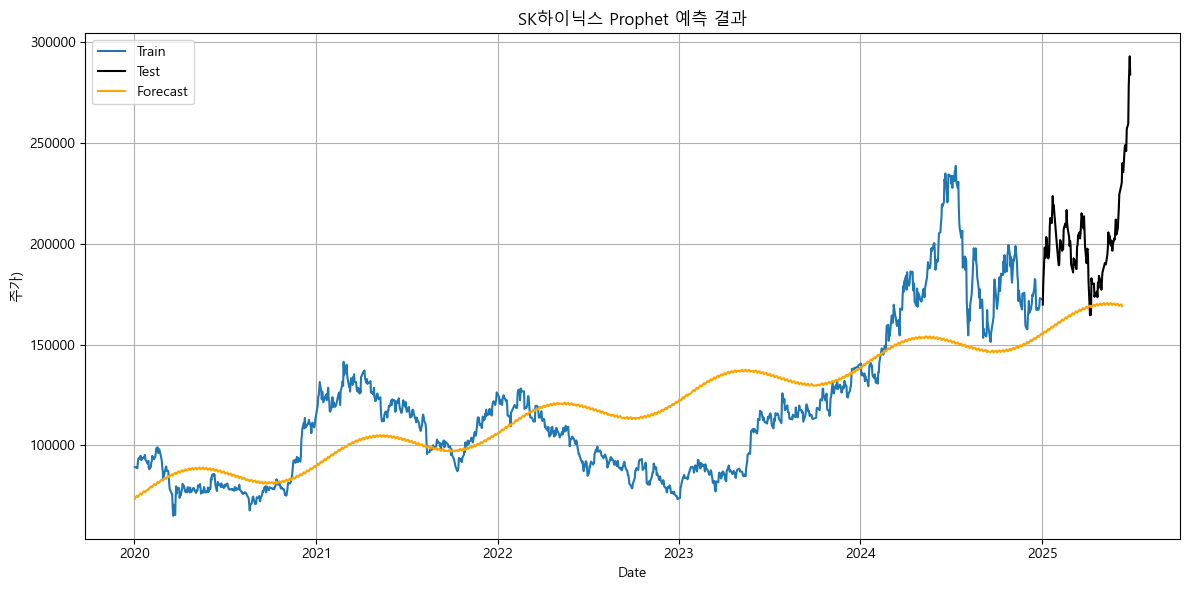

In [62]:
result_df = pd.DataFrame(results)
print(result_df)
best = result_df.sort_values(by='MAE').reset_index(drop=True)
print(best.head(1))

best_params = best.iloc[0]
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    changepoint_range=best_params['changepoint_range'],
    n_changepoints=best_params['n_changepoints'],
    yearly_seasonality=best_params['yearly'],
    weekly_seasonality=best_params['weekly'],
    daily_seasonality=best_params['daily']
)
final_model.fit(train)

future = final_model.make_future_dataframe(periods=len(test), freq='B')
forecast = final_model.predict(future)

plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test', color='black')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.title("SK하이닉스 Prophet 예측 결과")
plt.xlabel("Date")
plt.ylabel("주가)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()